# Basic Matrix Factorization

$R = UV'$ with gradient descent

In [1]:
#configure plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,5)
from matplotlib import pyplot as plt
from IPython.display import display

In [2]:
import numpy as np
import tensorflow as tf

In [3]:
%load_ext autoreload
%autoreload 2

In [7]:
from movieLensAnalyzer import MovieLensAnalyzer 
movieLensAnalyzer = MovieLensAnalyzer()
# Returns as a numpy array
userMovieRatingMatrix = movieLensAnalyzer.getUserMovieRatingMatrix()
print(userMovieRatingMatrix.shape)

(943, 1682)


# Dev

In [8]:
import random
## OLD
# R_    = np.array([[1,3,3,4,5],
#                   [1,2,4,3,5],
#                   [5,3,2,5,1]])
# mask_ = np.array([[1,1,1,1,1],
#                   [1,0,0,0,0],
#                   [1,1,1,1,1]])

# NEW
R_ = userMovieRatingMatrix
# random boolean mask for which values will be changed
# Below one liner only works for 50 percent
# mask_ = np.random.randint(0,2,size=userMovieRatingMatrix.shape) # Random integer 0 to 1 for 50% of it

# Hard code own percentagezero version to set random ones to 0 from mask
# TODO: Use more efficient numpy statements instead of for loops
percentageZero = 0.3 # Set 30 percent of data to be 0
mask_ = np.ones(userMovieRatingMatrix.shape)
# mask_ = np.ones((3,3))
for i in range(mask_.shape[0]):
    for j in range(mask_.shape[1]):
        if (random.random() < percentageZero):
            mask_[i][j] = 0

In [22]:
n_users, n_items = R_.shape
latent_dim = 2

R = tf.placeholder(tf.float32)
mask = tf.placeholder(tf.float32)

U = tf.Variable(tf.random_uniform([n_users, latent_dim], -1.0, 1.0), name='user_matrix')
V = tf.Variable(tf.random_uniform([n_items, latent_dim], -1.0, 1.0), name='item_matrix')

feed_dict = {
    R: R_,
    mask: mask_
}

reg_rate = 0.1
learning_rate = 0.0001

reg = tf.norm(U) + tf.norm(V)
error = tf.reduce_sum(tf.multiply(mask, tf.square(R - tf.matmul(U, V, transpose_b=True))))
loss = error + reg_rate * reg

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train = optimizer.minimize(loss)

initialize = tf.global_variables_initializer()

In [23]:
# Good way to quickly check your work as you go.
with tf.Session() as sess:
    sess.run(initialize)
    #print(sess.run(R, feed_dict))
    print(sess.run(loss, feed_dict))
    sess.run(train, feed_dict)
    print(sess.run(loss, feed_dict))
    sess.run(train, feed_dict)
    print(sess.run(loss, feed_dict))

313621.0
259188.0
221122.0


# Train 1 model

Final loss: 84959.2
Original:
[[ True  True  True ..., False False False]
 [ True False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [ True False False ..., False False False]
 [False False False ..., False False False]
 [False  True False ..., False False False]]
Reconstruction:
[[-0.02664386 -0.10504287  0.19897085 ..., -0.19251354  0.01495583
  -0.1807881 ]
 [ 0.00031104  0.01168121 -0.16036749 ...,  0.12308296 -0.05014349
   0.09949178]
 [ 0.04834625  0.15674737  0.15076321 ..., -0.04198428  0.13467856
   0.01269253]
 ..., 
 [ 0.03481462  0.12217475 -0.03201031 ...,  0.07724661  0.05253742
   0.09575799]
 [-0.04830159 -0.16579142 -0.0117185  ..., -0.06425685 -0.09063649
  -0.09826919]
 [-0.00121766  0.00810932 -0.18606257 ...,  0.14041133 -0.06101879
   0.1119855 ]]


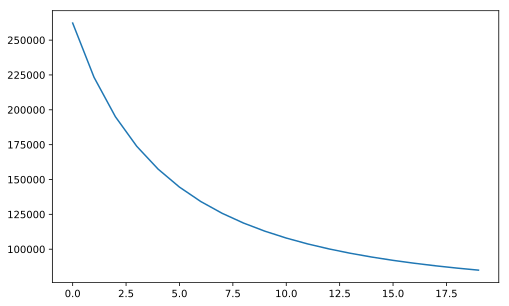

In [24]:
def train_model():
    losses = []
    R_hat = None
    with tf.Session() as sess:
        sess.run(initialize)
        #for i in range(100):
        for i in range(20):
            sess.run(train, feed_dict)
            losses.append(sess.run(loss, feed_dict))

        R_hat = sess.run(tf.matmul(U, V, transpose_b=True), feed_dict)
    return R_hat, losses
R_hat, losses = train_model()
print("Final loss:", losses[-1])
print("Original:")
print(R_)
print("Reconstruction:")
print(R_hat)
plt.plot(losses)
plt.show()

# Uncertainty(?) (warning: SLOW)

Not sure if this is the right way to get uncertainty (by just fitting this model over and over)

In [ ]:
final_R_hats = []
#for trial in range(100):
for trial in range(2):
    if trial % 10 == 0: print(trial)
    R_hat, _ = train_model()
    final_R_hats.append(R_hat)
final_R_hats = np.array(final_R_hats)

0


In [ ]:
# Visualize each value's uncertainty
f, axes = plt.subplots(n_users, n_items, sharex=True, sharey=True)
for i in range(n_users):
    for j in range(n_items):
        axes[i][j].hist(final_R_hats[:,i,j])

# TODO

- The "uncertainty" estimates are bad. In fact, I weren't able to even get good predictions by adjusting regularization. I wonder if the data is just too small.
- How to constrain it so ratings are positive? Maybe use Exponentiated Loss?
- Is there a better way to estimate uncertainty?